# Predicting Implicit Patterns and Optimizing Market Entry and Exit Decisions in Stock Prices using integrated Bayesian CNN-LSTM with Deep Q-Learning as a Meta-Labelle

**We are doing the following in this project**

- Train a Bayesian CNN-LSTM hybrid to predict the stock returns
- In the process estimate the uncertianty of the Bayesian CNN-LSTM prediction
- Use the Bayesian CNN--LSTM prediction and the uncertainty estimations as states to train Deep Q-learning agent (DQA).
- The purpose of training the DQA is to determine the size of bet based on Bayesian CNN-LSTM prediction and the uncertainty of the prediction of the Bayesian CNN-LSTM prediction

In [1]:
import datetime
import math

import numpy as np
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox,probplot,shapiro
# from sklearn_fracdiff import FracDiff
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField
from keras.models import Sequential
from keras.layers import Conv1D,Bidirectional, MaxPooling1D, Flatten, Dense,Reshape,LSTM,Dropout,TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from keras.optimizers import Adam
from keras import backend as keras_b
import tensorflow as tf
from keras.models import load_model
import random
from collections import deque
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (16, 9)

# **1. DATA COLLECTION FOR TRAINING & TESTING**

We will collect APPLE Stocks from 2005-01-01 to 2021-12-21

In [2]:
# Defined start and end dates for the data
start_date = '2010-01-01'
end_date = '2022-12-31'

# Fetch the data using the Yahoo Finance API
apple_data = yf.download('AAPL', start=start_date, end=end_date)
# Display the first few rows of the data
print(apple_data.head())
apple_data.to_csv("apple_stock_prices.csv")

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.470739  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.481928  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.378825  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.367033  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.409363  447610800


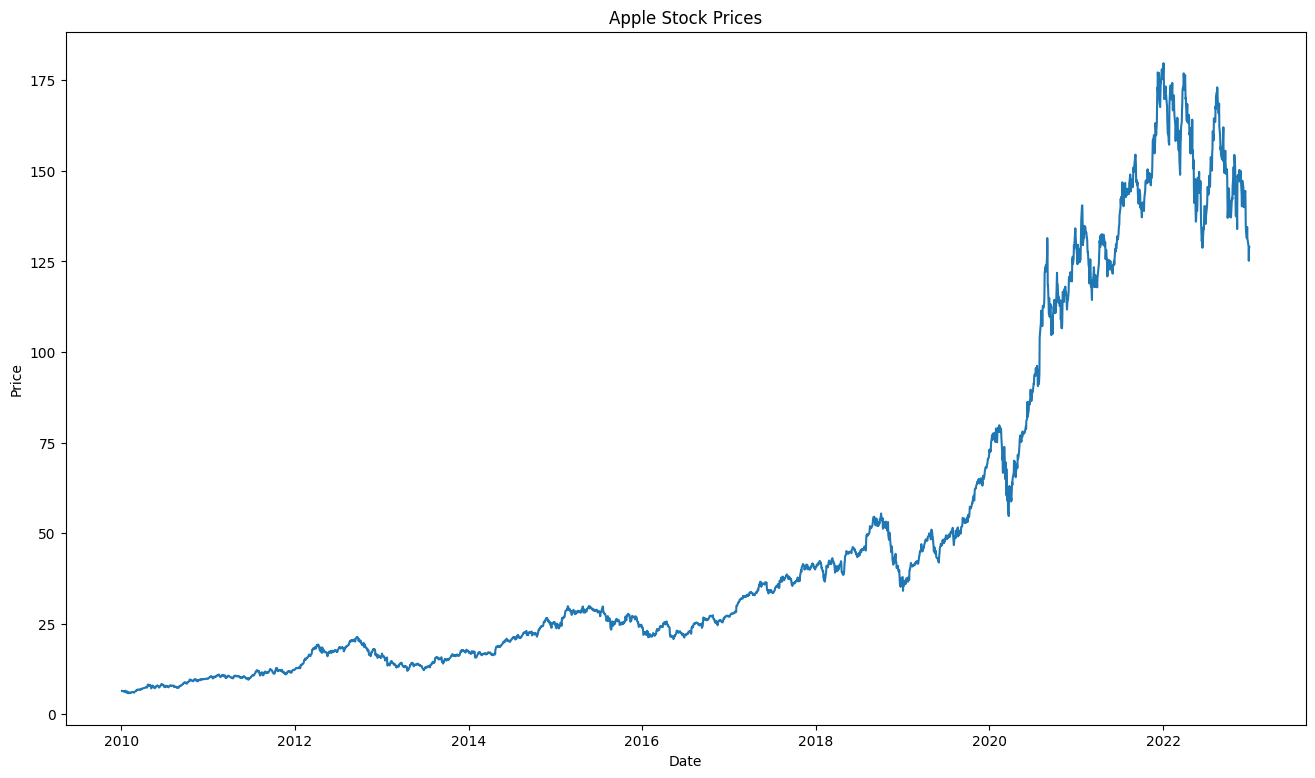

In [3]:
# Load the data from the CSV file
data = pd.read_csv("apple_stock_prices.csv")

# Convert the 'Date' column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Create the line plot
plt.plot(data["Date"], data["Adj Close"])
plt.title("Apple Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

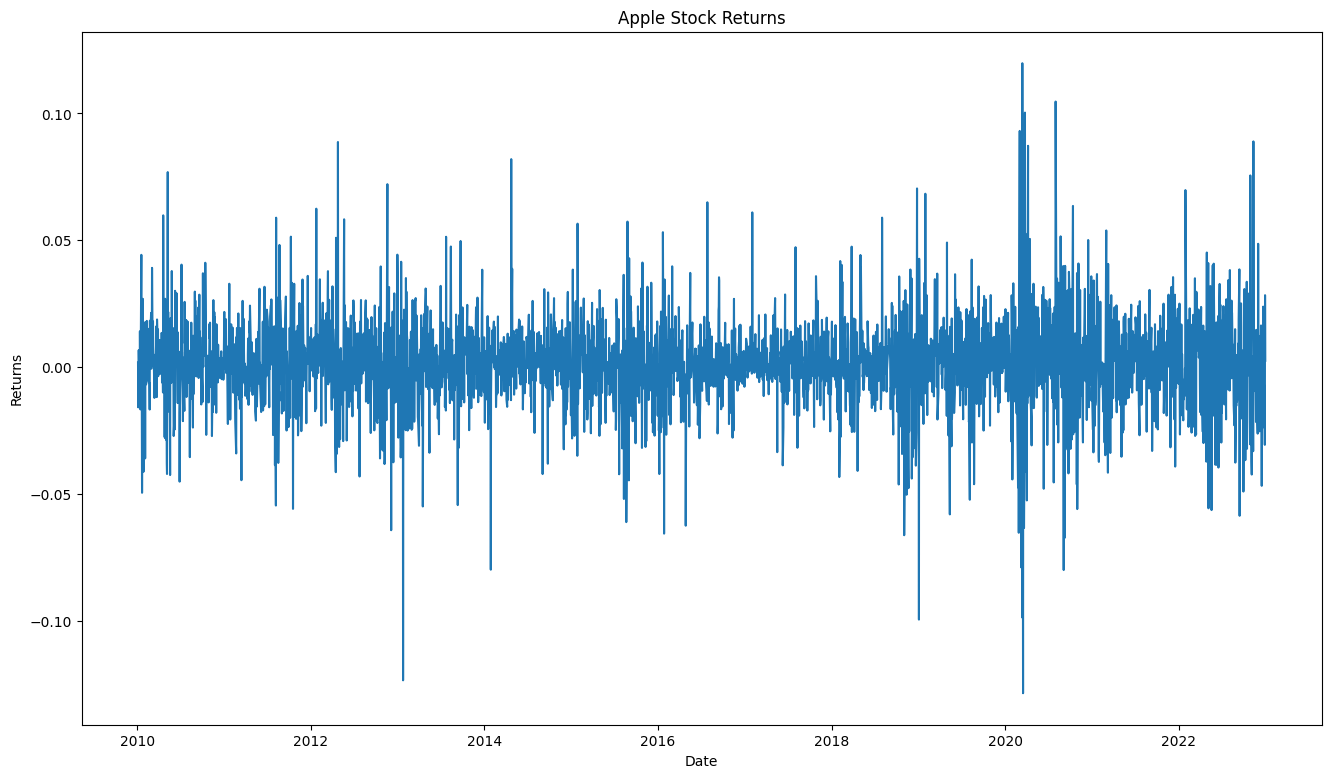

In [4]:
# Calculate the returns
data['Returns'] = data['Adj Close'].pct_change()


# Drop rows with missing values (NaNs) resulting from the shifting
data.dropna(inplace=True)
# Create the line plot
plt.plot(data["Date"], data["Returns"])
plt.title("Apple Stock Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800,0.001729
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000,-0.015906
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,-0.001849
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409363,447610800,0.006648
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.352823,462229600,-0.008821


# **2 Reprocess the return**

- For each window of 100 consecutive data points,`X[i]`, the percentage change $\delta x_i$ is calculated relative to the first data point in the window. This is represented by:

  $$\delta x_i = \frac{x_{100+i} - x_i}{x_i}$$

  where $x_{100+i}$ is the value at the end of the window (i.e., the 100th data point), and $x_i$ is the value at the start of the window (i.e., the 1st data point).

- For the corresponding target value,  `Y[i]`, the percentage change $\delta y_i$ is calculated as the difference between the value at the next time step (i.e., $x_{101+i}$) and the value at the start of the window (i.e., $x_i$), divided by the value at the start of the window. This is represented by:

  $$\delta y_i = \frac{x_{101+i} - x_i}{x_i}$$

Consequently, `X[i]` represents the percentage change within the window, and `Y[i]` represents the percentage change at the next time step after the window.

In [6]:
X = []
Y = []
window_size=100
for i in range(1 , len(data) - window_size -1 , 1):
    first = data.iloc[i,5]
    # print(first)
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data.iloc[i + j, 5] - first) / first)
    temp2.append((data.iloc[i + window_size, 5] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))
# Split the data into training, validation, and testing sets
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(
    X, Y, test_size=0.2, shuffle=True
)

# # Further split the training set into training and validation sets
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True
)

X_train = np.array(X_train_)
X_test = np.array(X_test_)
X_val = np.array(X_val_)
y_train = np.array(y_train_)
y_val = np.array(y_val_)
y_test = np.array(y_test_)
# # Reshape the input data for CNN (channels last)
X_train = X_train.reshape(X_train.shape[0],1,100,1)
X_val = X_val.reshape(X_val.shape[0],1,100,1)
X_test = X_test.reshape(X_test.shape[0],1,100,1)

print(len(X_train))
print(len(X_val))
print(len(X_test))

2028
507
634


In [7]:
# y_test

In [8]:
len(X)

3169


# **3. Training the Bayesian CNN-LSTM**

Combining Monte Carlo Dropout (MC Dropout) with a Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) network involves extending the MC Dropout methodology to both the CNN and LSTM components. Below are the steps to incorporate MC Dropout into a hybrid Bayesian CNN-LSTM model:

1. **Modify the CNN-LSTM Architecture:**
   - Introduce dropout layers after convolutional layers in the CNN part and after the LSTM layers in the LSTM part of your architecture.

In [9]:
# For creating model and training
model_bay_cnn_lstm = Sequential()

# Creating the Neural Network model here...
# CNN layers
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 1,100, 1)
              )
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Dropout(0.25)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(128, kernel_size=3, activation='relu')
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu')
    )
)
model_bay_cnn_lstm.add(TimeDistributed(MaxPooling1D(2)))
model_bay_cnn_lstm.add(TimeDistributed(Flatten()))

# LSTM layers
model_bay_cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
model_bay_cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
model_bay_cnn_lstm.add(Dropout(0.5))

#Final layers
model_bay_cnn_lstm.add(Dense(1, activation='linear'))
model_bay_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

2. **Enable Dropout During Inference:**
   
  To perform MC Dropout during inference, we need to manually enable dropout at test time. This involves setting the training parameter of the model to True during inference. This step is crucial for obtaining multiple predictions with varying dropout masks..

In [10]:
def enable_dropout(model_bay_cnn_lstm):
    for layer in model_bay_cnn_lstm.layers:
        if isinstance(layer, (Dropout, LSTM, TimeDistributed)):
            layer.training = True


3. **Training:**
   We train the model as we would with a standard CNN, but with the dropout layers included. The dropout layers are automatically active during training.

In [11]:
# # Train the model

history = model_bay_cnn_lstm.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=0
)


4. **Perform Multiple Predictions:**
   - When making predictions,we  enable dropout during inference, and make multiple predictions to capture uncertainty.

In [12]:
num_predictions = 100
predictions = []

for _ in range(num_predictions):
    enable_dropout(model_bay_cnn_lstm)
    pred = model_bay_cnn_lstm.predict(X_test,verbose=0)  # x_test is your test data
    predictions.append(pred)

predictions = np.array(predictions)


5. **Aggregating Predictions:**
   
We aggregate the predictions to obtain a measure of uncertainty. We shall use the mean or variance of the predictions as aggregation method. The mean prediction provides an estimate of the point prediction, while the variance can be considered a measure of uncertainty..

In [13]:
mean_prediction = np.mean(predictions, axis=0)
uncertainty = np.var(predictions, axis=0)


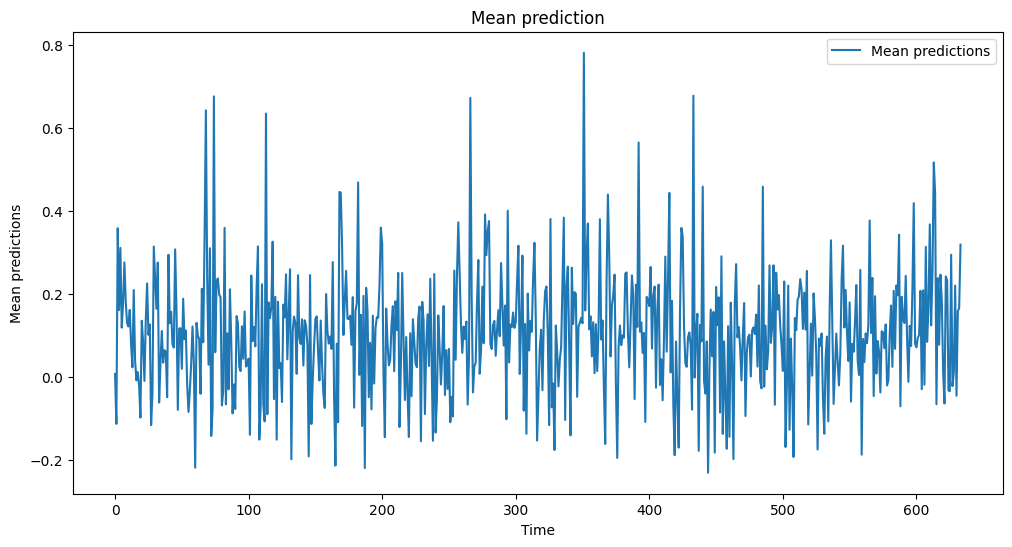

In [14]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(mean_prediction, label='Mean predictions')
plt.xlabel('Time')
plt.ylabel('Mean predictions')
plt.title('Mean prediction')
plt.legend()
plt.show()

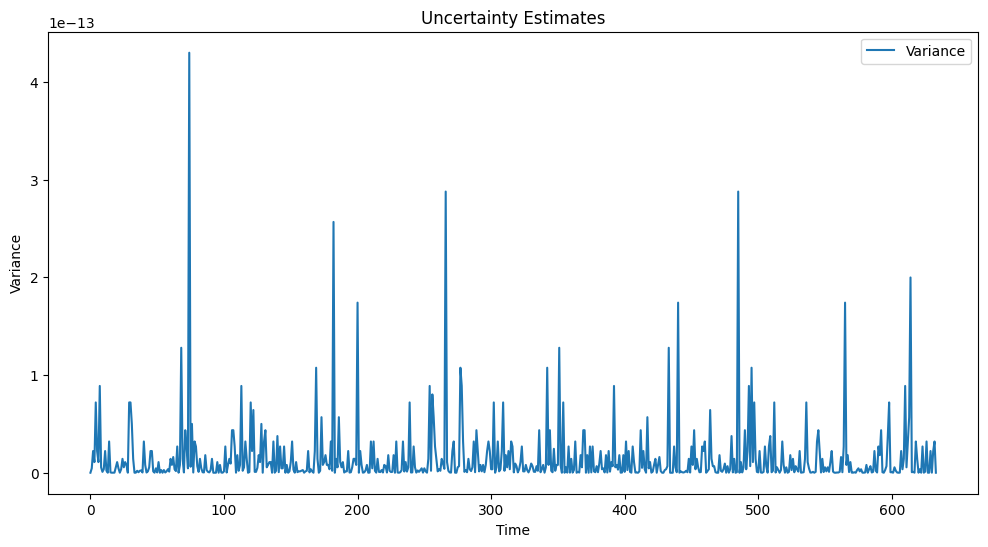

In [84]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(uncertainty, label='Variance')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Uncertainty Estimates')
plt.legend()
plt.show()

**Save the Bayesian CNN-LSTM model**

In [16]:
# Save the model architecture as JSON
model_bay_cnn_lstm_json = model_bay_cnn_lstm.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_bay_cnn_lstm_json)

# Save the model weights
model_bay_cnn_lstm.save_weights("trained_bayesian_CNN_LSTM_weights.h5")

# Optionally, saving the entire model (including architecture and weights) in a single .h5 file
model_bay_cnn_lstm.save("complete_bayesian_cnn_lstm.h5")

# model_bay_cnn_lstm.save_weights('trained_bayesian_CNN_LSTM_weights.h5')

In [17]:
# # Evaluate the model on the validation and test sets
val_loss = model_bay_cnn_lstm.evaluate(X_val, y_val)
test_loss = model_bay_cnn_lstm.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Test loss:", test_loss)

# Make predictions
y_pred = model_bay_cnn_lstm.predict(X_test)

20/20 [==============================] - 0s 13ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0527
Validation loss: [0.00416029104962945, 0.00416029104962945, 0.05039598047733307]
Test loss: [0.00464910501614213, 0.00464910501614213, 0.05272848531603813]
20/20 [==============================] - 1s 18ms/step


In [18]:
X_test.shape

(634, 1, 100, 1)

In [19]:
y_pred.shape

(634, 1)

In [20]:
y_test_list=[]
for i in y_test:
    y_test_list.append(i)

In [21]:
data2=pd.DataFrame(y_pred,columns=["pred"])
data2["real"]=y_test_list

In [22]:
# y_test

In [23]:
# data2.head(10)

20/20 [==============================] - 0s 12ms/step


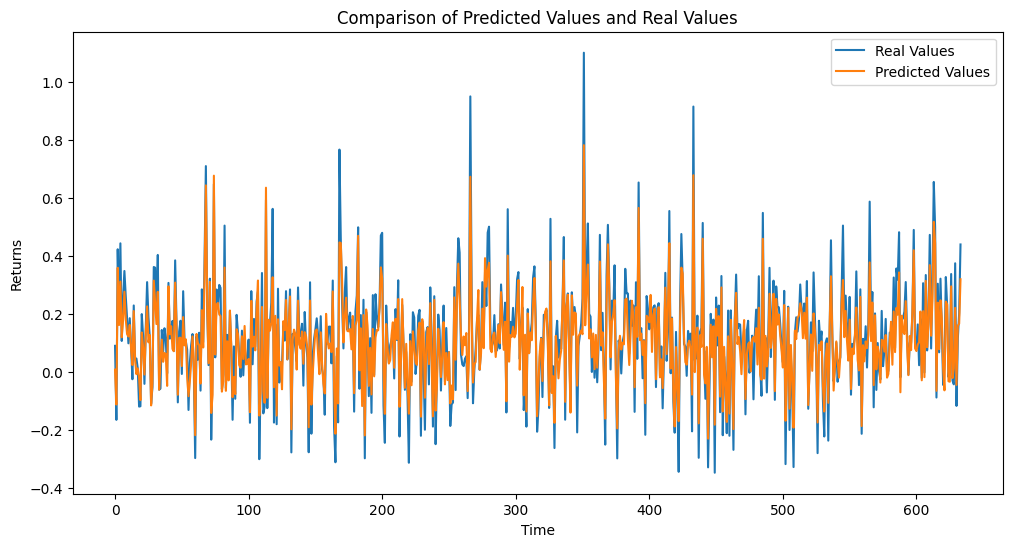

In [24]:
# Plot the graph comparing predicted values and real values
y_pred = model_bay_cnn_lstm.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(data2['real'], label='Real Values')
plt.plot(data2['pred'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Comparison of Predicted Values and Real Values')
plt.legend()
plt.show()

# **5.Market Timing with Deep Q-learning**

In [25]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states():
    # create an extended state that incorporated uncertainty estimation
    # and the predictions
    # We limit the state size to 100*2
    # This is necessary to maintain consistency
    extended_state = np.concatenate((y_pred[:100,:], uncertainty[:100,:]), axis=1)
    return extended_state

# The DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200)  # Experience replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = keras_b.abs(error) <= clip_delta

        squared_loss = 0.5 * keras_b.square(error)
        quadratic_loss = (
                    0.5 * keras_b.square(clip_delta) +
                    clip_delta * (keras_b.abs(error) - clip_delta)
                )

        return keras_b.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(state_size, 2)))  # Flatten layer to reshape input
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(
            loss=self._huber_loss, 
            optimizer=Adam(learning_rate=self.learning_rate)
        )
        # model = Sequential()
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # print(state.shape)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,current_holding=0):
        if np.random.rand() <= self.epsilon:
            # Randomly select action from the action space: short, do nothing, long
            return np.random.uniform(-1, 1)
        else:
            # Use the Q-network to select action based on state
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # print(next_state.shape)
            if not done:
                # print(self.model.predict(next_state))
                target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
            # print(state.shape)
            target_f = self.model.predict(state,verbose=0)
            # print(action)
            target_f[0][0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# The Market environment
class MarketEnvironment:
    def __init__(self, max_episode_length=100, min_available_capital=10, max_trades=None, profit_target=None, stop_loss=-5000):
        self.state_size = state_size  # The actual size of your state
        self.action_size = 1  # Example: Buy, Sell, Hold
        self.initial_capital = 10000  # Initial available capital
        self.transaction_cost = 0.01  # Transaction charge (1%)
        self.current_capital = self.initial_capital
        self.max_episode_length = max_episode_length
        self.min_available_capital = min_available_capital
        self.max_trades = max_trades
        self.profit_target = profit_target
        self.stop_loss = stop_loss
        self.num_trades = 0
        self.total_reward = 0
        self.uncertainty_penalty=0.5

    def reset(self):
        # Reset logic
        self.current_capital = self.initial_capital
        self.num_trades = 0
        self.total_reward = 0
        # print(self.state_size)
        return np.random.rand(self.state_size)

    def step(self, action,time_state):
        # Extract market returns and uncertainty from the state
        market_returns = time_state[0]  # First column contains predicted market returns
        uncertainty = time_state[1]     # Second column contains uncertainty estimations
        # Simulated step function, returns next_state, reward, done
        next_state = np.random.rand(self.state_size,2)

        # Calculate bet size based on the selected action
        bet_size = abs(action) * self.current_capital

        # Calculate transaction cost based on the bet size
        total_transaction_cost=self.transaction_cost * bet_size
        # Subtract the transaction cost
        self.current_capital -= total_transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns * bet_size
        yield_size=return_amount+bet_size
        if action > 0:
            # Adjust available capital based on bet size
            self.current_capital += return_amount
    
        # If action == 0, it means the agent wants to close the position
        elif action == 0:
            # Adjust available capital based on the current holding
            self.current_capital += return_amount
        # Calculate reward based on market return, transaction charges, and uncertainty
        reward = return_amount
        reward -= self.uncertainty_penalty * uncertainty
        # Increment total reward
        self.total_reward += reward

        # Increment number of trades
        self.num_trades += 1
         # Check termination conditions
        done = False
        if self.num_trades >= self.max_episode_length:
            done = True
        elif self.current_capital <= self.min_available_capital:
            done = True
        elif self.max_trades is not None and self.num_trades >= self.max_trades:
            done = True
        elif self.profit_target is not None and self.total_reward >= self.profit_target:
            done = True
        elif self.stop_loss is not None and self.total_reward <= self.stop_loss:
            done = True
        return next_state, reward, done


In [26]:
# EPISODE LENGTH
# This is equivalent to the time steps we would want our agent to master
EPISODE_LENGTH=10
EPISODES=20

In [27]:
# Hyperparameters
states=get_states()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# # market return

# Create the environment and agent
env = MarketEnvironment()
agent = DQNAgent(state_size, action_size)


# Training the DQN agent
for episode in range(EPISODES):  # Replace with the desired number of episodes
    state = env.reset()
    state_from_cnn_lstm = get_states()
    # state=state_from_lstm
    state = np.reshape(state_from_cnn_lstm, [1, state_size, 2])
    # print(state)
    total_episode_reward = 0  # Initialize total reward for the episode

    for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
        action = agent.act(state)
        # print(market_returns_array[time])
        # Get this time state for reward calculation
        # print(state.shape)
        time_state=state[0][time]
        # print(time_state,time,episode)
        next_state, reward, done = env.step(action,time_state)
        next_state = np.reshape(next_state, [1, state_size, 2])
        # print(state.shape)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward  # Accumulate the reward obtained at each time step
        if done:
            print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
            break
        # print(batch_size)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

200
100
Episode: 1/20, Reward score: -6728.599118461669
Episode: 3/20, Reward score: -9089.823324287203
Episode: 4/20, Reward score: -8707.089913913369
Episode: 5/20, Reward score: -7491.036001300953
Episode: 6/20, Reward score: -8162.555831722348
Episode: 7/20, Reward score: -8332.317395426022
Episode: 8/20, Reward score: -8050.878484848778
Episode: 10/20, Reward score: -7992.851100720094
Episode: 11/20, Reward score: -5944.400200628172
Episode: 12/20, Reward score: -6557.1933453935535
Episode: 13/20, Reward score: -6841.712418080539
Episode: 15/20, Reward score: -6614.9317863355145


## Save model weights

In [28]:
# Save DQNAgent object weights
agent.model.save_weights('trained_qql_weights.h5')
# Assuming your agent is called 'agent'


# Save the agent's configurations using pickle
agent_config = {
    'state_size': agent.state_size,
    'action_size': agent.action_size,
    # Add any other relevant configurations of your agent here
}
print(agent_config)
with open("trained_qql_agent_config.pkl", "wb") as config_file:
    pickle.dump(agent_config, config_file)

{'state_size': 100, 'action_size': 1}


# **Backtest the models**

**Collect market data**

In [29]:
# Define the start and end dates for the live market data
start_date_live = '2023-01-01'
end_date_live = '2024-01-31'

# Fetch the data using the Yahoo Finance API
apple_data_live = yf.download('AAPL', start=start_date_live, end=end_date_live)
# Display the first few rows of the data
print(apple_data_live.head())
apple_data_live.to_csv("apple_stock_prices_live.csv")

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.216293   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.497505   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.166641   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.735245   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.261627   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


In [30]:
# Load the data from the CSV file
data_live = pd.read_csv("apple_stock_prices_live.csv")


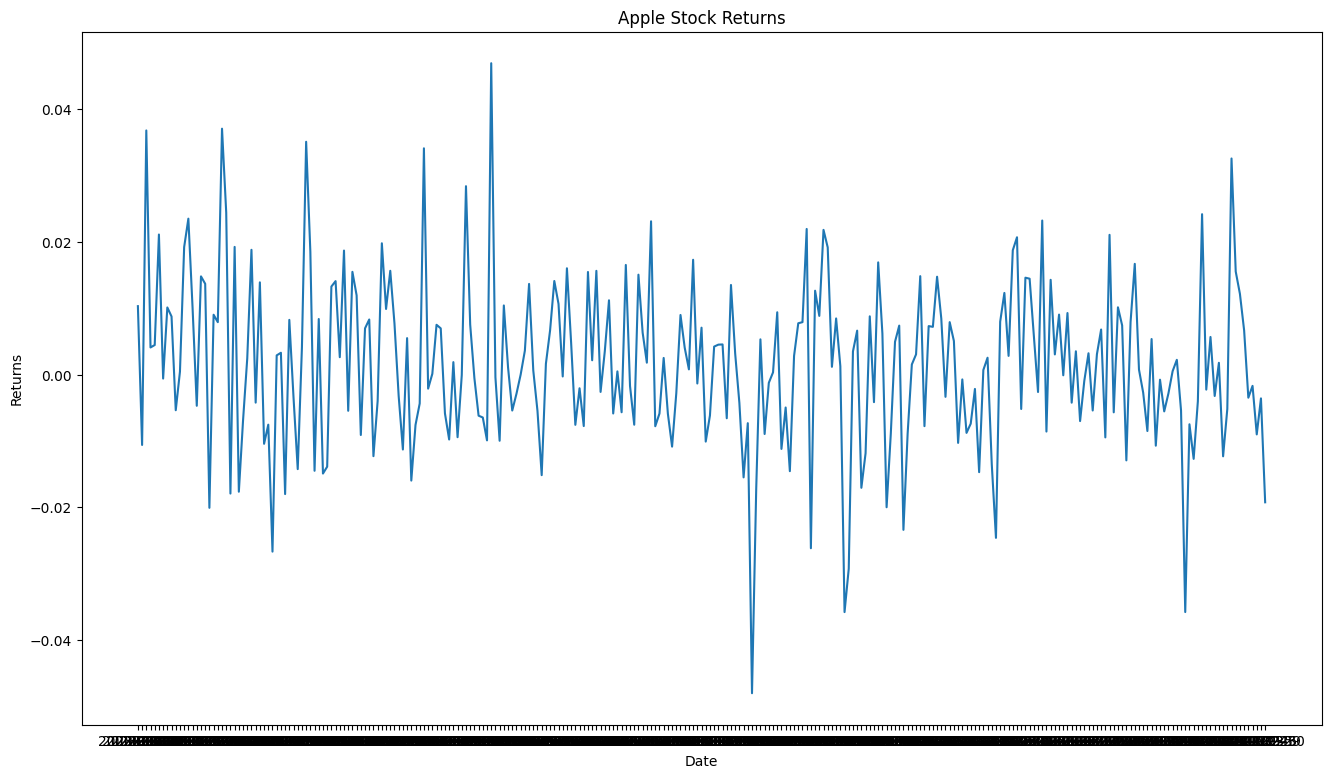

In [31]:
# Calculate the returns
data_live['Returns'] = data_live['Adj Close'].pct_change()


# Drop rows with missing values (NaNs) resulting from the shifting
data_live.dropna(inplace=True)
# Create the line plot
plt.plot(data_live["Date"], data_live["Returns"])
plt.title("Apple Stock Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

**Preprocess for Bayesian CNN-LSTM predictions**

In [32]:
X_live = []
y_live = []
window_size=100
for i in range(1 , len(data_live) - window_size -1 , 1):
    first = data_live.iloc[i,5]
    # print(first)
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data_live.iloc[i + j, 5] - first) / first)
    temp2.append((data_live.iloc[i + window_size, 5] - first) / first)
    X_live.append(np.array(temp).reshape(100, 1))
    y_live.append(np.array(temp2).reshape(1, 1))


X_live = np.array(X_live)
y_live = np.array(y_live)
# # Reshape the input data for CNN (channels last)
X_live = X_live.reshape(X_live.shape[0],1,100,1)

print(len(X_live))
print(len(y_live))

167
167


In [33]:
# X_live

**Load the trained and saved Bayesian CNN-LSTM model**

In [34]:
# Load the saved model
loaded_bay_cnn_lstm_model = load_model('complete_bayesian_cnn_lstm.h5')

**Make Bayesian CNN-LSTM predictions**

6/6 [==============================] - 3s 15ms/step - loss: 0.0027 - mse: 0.0027 - mae: 0.0429
Prediction loss: [0.0027094960678368807, 0.0027094960678368807, 0.0429401770234108]


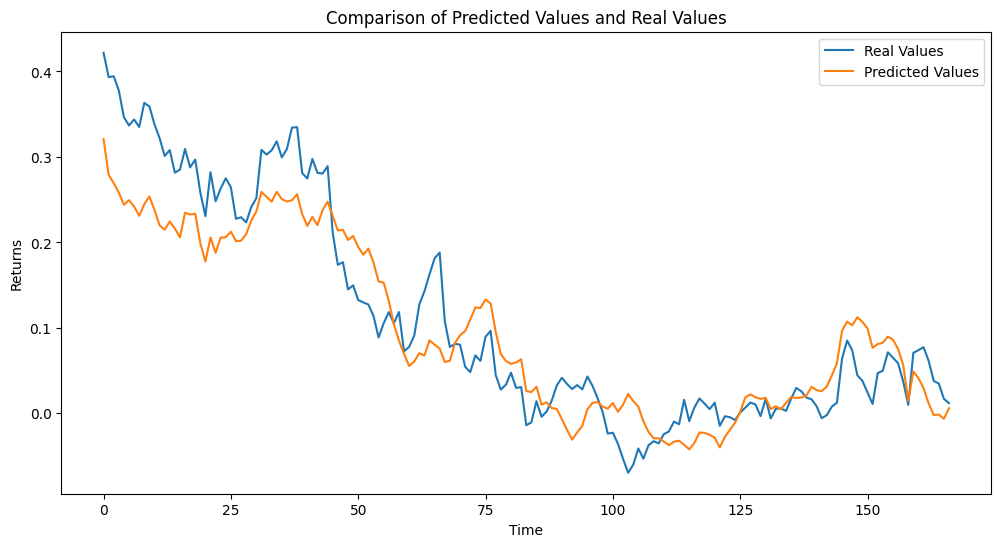

In [35]:
# Plot the graph comparing predicted values and real values
y_pred_live = loaded_bay_cnn_lstm_model.predict(X_live)
pred_loss = loaded_bay_cnn_lstm_model.evaluate(X_live, y_live)
print("Prediction loss:", pred_loss)
y_live_list=[]
for i in y_live:
    y_live_list.append(i[0][0])
data_live_2=pd.DataFrame(y_pred_live,columns=["pred"])
data_live_2["real"]=y_live_list  
plt.figure(figsize=(12, 6))
plt.plot(data_live_2['real'], label='Real Values')
plt.plot(data_live_2['pred'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Comparison of Predicted Values and Real Values')
plt.legend()
plt.show()

**Estimate uncertainty**

In [36]:
num_predictions_live = 100
predictions_live = []

for _ in range(num_predictions_live):
    enable_dropout(loaded_bay_cnn_lstm_model)
    pred = loaded_bay_cnn_lstm_model.predict(X_live,verbose=0) 
    predictions_live.append(pred)

predictions_live = np.array(predictions_live)


**Aggregate uncertianty**

In [37]:
mean_prediction_live = np.mean(predictions_live, axis=0)
uncertainty_live = np.var(predictions_live, axis=0)

In [38]:
# mean_prediction_live

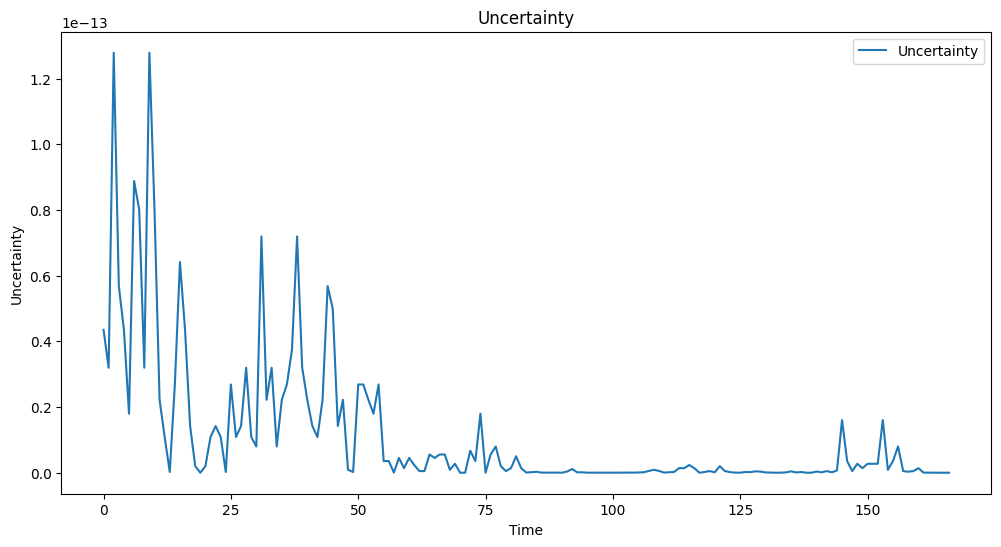

In [39]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(uncertainty_live, label='Uncertainty')
plt.xlabel('Time')
plt.ylabel('Uncertainty')
plt.title('Uncertainty')
plt.legend()
plt.show()

In [40]:
y_pred_live.shape


(167, 1)

**Load the Deep Q-learning weights**

In [41]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states_live():
    # create an extended state that incorporated uncertainty estimation
    # and the predictionsd
    extended_state = np.concatenate(
        (y_pred_live[:100,:], 
         uncertainty_live[:100,:]),
        axis=1
    )
    return extended_state


# # Hyperparameters
states=get_states_live()
state_size = states.size # The actual size of your state
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# market return
# Load trained model weights
loaded_dqq_agent = DQNAgent(state_size, action_size)
loaded_dqq_agent.model.load_weights('trained_qql_weights.h5')

100


**Make bet size predictions**

In [42]:

# Predict actions (sizes of bets)
actions_live = []
for state in states:
    action = loaded_dqq_agent.act(state)
    actions_live.append(action)

# print("Predicted actions:", actions_live)

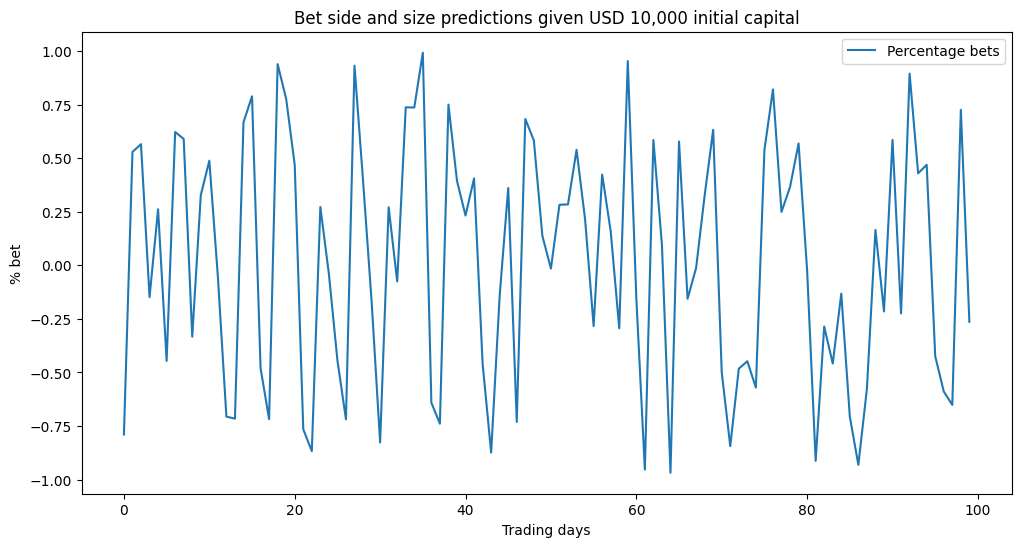

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(actions_live, label='Percentage bets')
plt.xlabel('Trading days')
plt.ylabel('% bet')
plt.title('Bet side and size predictions given USD 10,000 initial capital')
plt.legend()
plt.show()

In [44]:
def evaluate_actions(actions, market_returns, initial_capital=10000,num_trades=10):
    """
    Evaluate the performance of actions in the market.

    Args:
    - actions (list): List of actions taken by the agent (sizes of bets).
    - market_returns (numpy.ndarray): Array of actual market returns.
    - initial_capital (float): Initial capital for trading. Default is 10000.

    Returns:
    - cumulative_return (float): Cumulative return after trading.
    """
    capital = initial_capital
    num_trades = num_trades
    total_return = 0
    profit_loss=[]
    cum_capital=list()
    cum_capital.append(initial_capital)

    for i, action in enumerate(actions):
        if i>num_trades:
            break
        # Calculate bet size based on the selected action
        bet_size = abs(action) * capital

        # Calculate transaction cost based on the bet size (assuming 1% transaction cost)
        transaction_cost = 0.01 * bet_size

        # Subtract transaction cost from capital
        capital -= transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns[i][0][0] * bet_size
        profit_loss.append(return_amount)
        # Calculate yield size (bet size + market return amount)
        # print("Action=",action)
        # print("bet_size=",bet_size)
        # print("Market return",market_returns[i][0][0])
        yield_size = return_amount + bet_size
        # print("Return amount=",return_amount)
        # print("yield_size=",yield_size)
        
        # Update capital and holding based on action
        if action > 0:
            # Going long
            capital += return_amount
        elif action < 0:
            # Going short
            capital += return_amount

        # Increment total reward
        total_return += return_amount
        cum_capital.append(capital)
    # Calculate cumulative return
    cumulative_return = ((total_return)/initial_capital)*100

    return total_return,cumulative_return,num_trades,profit_loss,cum_capital

In [91]:
cum_reward=evaluate_actions(
    actions=actions_live,
    market_returns=y_live,
    num_trades=10
)

In [92]:
data_live_4=pd.DataFrame(cum_reward[4],columns=["Capital"])
data_live_4.head()

,Capital
0,10000.000000
1,6589.546410
2,7926.225069
3,9648.420083
4,9093.632226


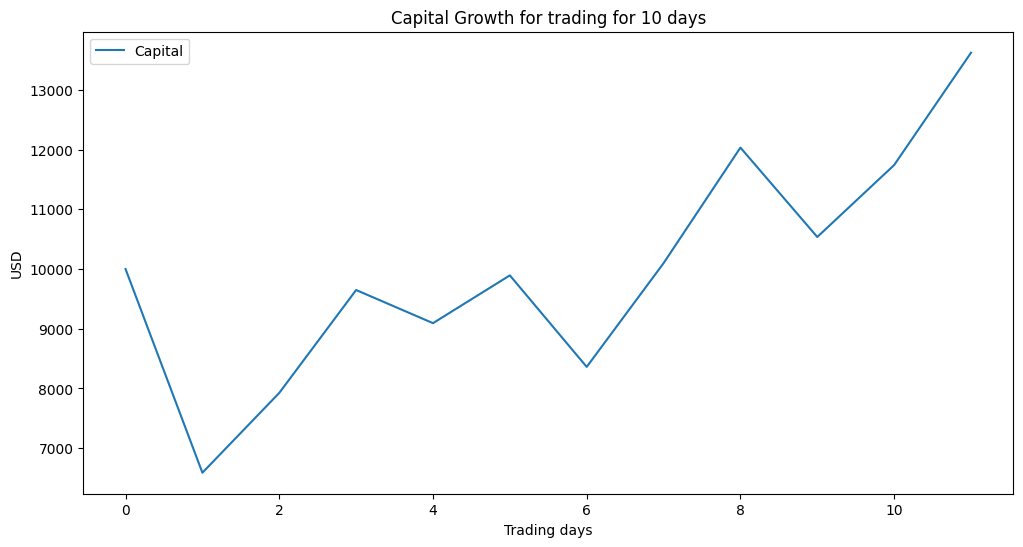

In [93]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_4['Capital'], label='Capital')
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Capital Growth for trading for 10 days')
plt.legend()
plt.show()

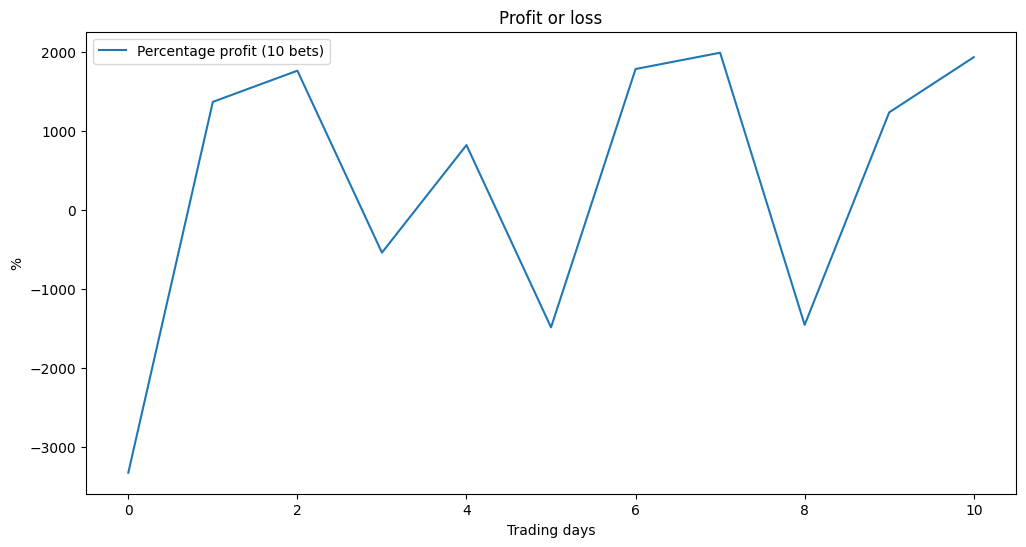

In [94]:
data_live_3=pd.DataFrame(cum_reward[3],columns=["profit"])
plt.figure(figsize=(12, 6))
plt.plot(data_live_3['profit'], label='Percentage profit (10 bets)')
plt.xlabel('Trading days')
plt.ylabel('%')
plt.title('Profit or loss')
plt.legend()
plt.show()

In [95]:
print(
    f"Total profit = {cum_reward[0]}",
    f"%-profit = {cum_reward[1]}",
    f"Total trades = {cum_reward[2]}"
    )

Total profit = 4105.757482097736 %-profit = 41.05757482097736 Total trades = 10


**Agents performance based on number of trades allowed to place**

In [104]:
num_trades_profits=[]
num_trades_percentage_profits=[]
for i in range(1,101):
    cum_reward=evaluate_actions(
        actions=actions_live,
        market_returns=y_live,
        num_trades=i
    )
    num_trades_profits.append(cum_reward[0])
    num_trades_percentage_profits.append(cum_reward[1])

In [67]:
# num_trades_profits

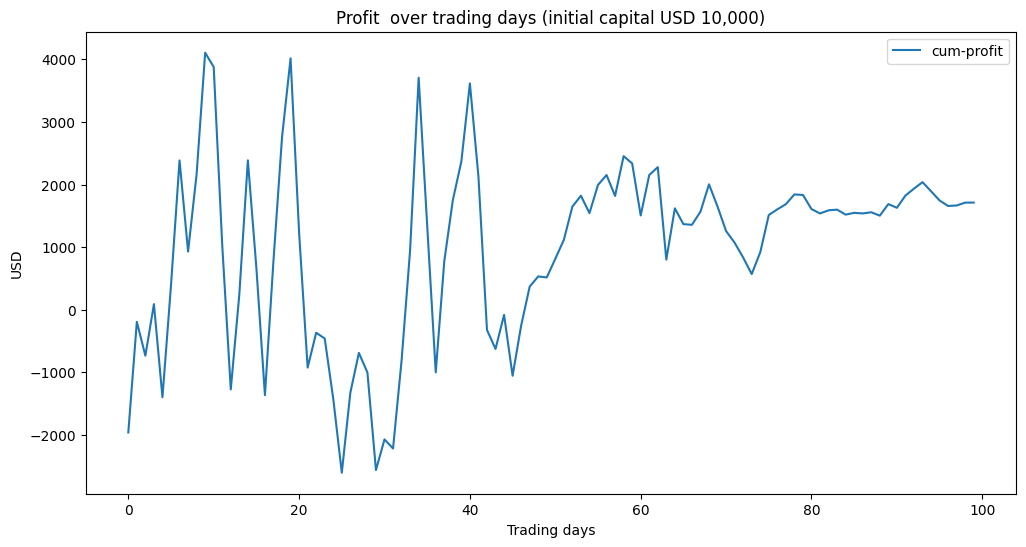

In [105]:
data_live_5=pd.DataFrame(num_trades_profits,columns=["profit"])
data_live_5['percentage_profit']=num_trades_percentage_profits
plt.figure(figsize=(12, 6))
plt.plot(data_live_5['profit'], label="cum-profit")
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Profit  over trading days (initial capital USD 10,000)')
plt.legend()
plt.show()

In [82]:
data_live_5.head()

,profit,percentage_profit
0,-1959.948850,-19.599488
1,-192.947910,-1.929479
2,-733.424982,-7.334250
3,90.291884,0.902919
4,-1397.667655,-13.976677


In [ ]:
# 